# [Wilson-Cowan SDE model in Numba](https://github.com/Ziaeemehr/vbi_paper/blob/main/docs/examples/wilson_cowan_sde_numba.ipynb)


<a href="https://colab.research.google.com/github/Ziaeemehr/vbi_paper/blob/main/docs/examples/wilson_cowan_sde_numba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import vbi
import torch
import numpy as np
import networkx as nx
from copy import deepcopy
import sbi.utils as utils
import multiprocessing as mp
from scipy.signal import welch
import matplotlib.pyplot as plt
from sbi.analysis import pairplot
from vbi.sbi_inference import Inference
from vbi.models.numba.wilson_cowan import WC_sde

import warnings
warnings.filterwarnings("ignore")

In [2]:
seed = 42
np.random.seed(seed)

In [3]:
LABESSIZE = 10
plt.rcParams['axes.labelsize'] = LABESSIZE
plt.rcParams['xtick.labelsize'] = LABESSIZE
plt.rcParams['ytick.labelsize'] = LABESSIZE

To change the frequency of oscillations in this model, there are several key parameters to adjust:

1. Coupling strengths
2. Time constants 
3. External inputs
4. Refractory periods 
5. Sigmoid function parameters

Sweeping over External current to Excitatory population (P)

In [4]:
ns = 30
P_values = np.linspace(0, 3, ns)
weights = np.array([[0, 1], [1, 0]], dtype=np.float32)

par = dict(
    weights=weights,
    dt=0.1,
    t_end=2000.0,
    t_cut=101.0,
    noise_amp=0.001,
    g_e=0.0,
    g_i=0.0,
    P=1.22,
    RECORD_EI="EI",
    decimate=1,
    seed=seed,
)

In [5]:
def wrapper(par, p):
    sim = WC_sde(par)
    sol = sim.run({'P': p})
    return sol

with mp.Pool(processes=4) as pool:
    results = pool.starmap(wrapper, [(par, p) for p in P_values])
    results = [sol for sol in results if sol is not None]

t = results[0]["t"]
E = np.array([results[i]["E"] for i in range(len(results))])
I = np.array([results[i]["I"] for i in range(len(results))])

print(t.shape, E.shape, I.shape) # nsim, ntime, nnodes

(18990,) (30, 18990, 2) (30, 18990, 2)


Sweeping over Bifurcation parameter P

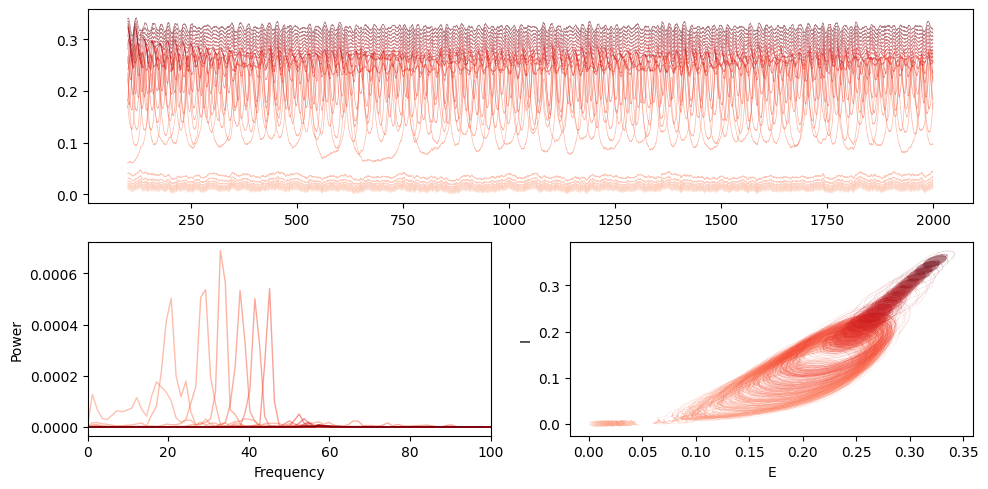

In [6]:
f, P_E = welch(E[:, :, 0], fs=1/(par["dt"]*par['decimate']) * 1000, nperseg=8*1024, axis=1)

mosaic = """
AA
BC
"""
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ax = fig.subplot_mosaic(mosaic)

colors = plt.cm.Reds(np.linspace(0.1,1.0, ns))
for i in range(ns):
    ax['A'].plot(t, E[i, :, 0], alpha=0.5, lw=0.5, color=colors[i])

for i in range(ns):
    ax['B'].plot(f, P_E[i,:], alpha=0.5, lw=1, color=colors[i], label=f"{P_values[i]:.2f}")

for i in range(ns):
    ax['C'].plot(E[i, :, 0], I[i, :, 0], lw=0.1, alpha=0.5, color=colors[i])

ax['B'].set_xlabel("Frequency")
ax['B'].set_ylabel("Power")
ax['B'].set_xlim(0, 100)
ax['C'].set_xlabel("E")
ax['C'].set_ylabel("I")
# ax['B'].legend(ncol=2)
plt.tight_layout()

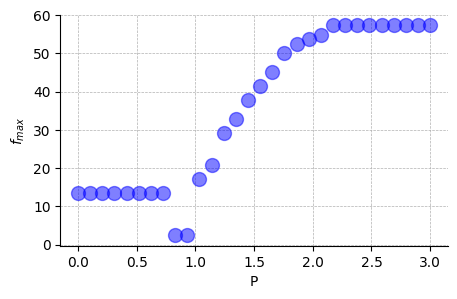

In [7]:
idx_max = np.argmax(P_E, axis=1)
fmax = f[idx_max]
fig, ax = plt.subplots(1, figsize=(5,3))
ax.plot(P_values, fmax, "bo", ms=10, alpha=0.5)
ax.grid(True, ls='--', lw=0.5)
ax.set_xlabel("P")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel(r"$f_{max}$");

(37980,) (37980, 2) (37980, 2)


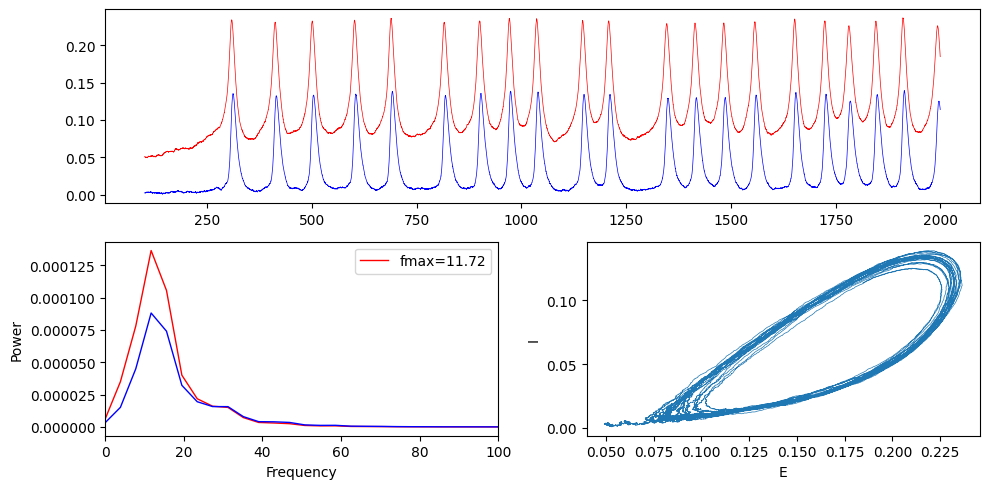

In [8]:

weights = np.array([[0,1],[1,0]], dtype=np.float32)
P = 1.025

par = {
    "g_e": 0.0,
    "seed": 42,
    "dt": 0.05,
    "t_end": 2000.0,
    "t_cut": 101.0,
    "noise_amp": 0.0005, # add small amount of noise
    "decimate": 1,
    "P": P,
    "RECORD_EI": "EI",
    "weights": weights,
}

sim = WC_sde(par)
sol = sim.run()
t = sol["t"]
E = sol["E"]
I = sol["I"]

print(t.shape, E.shape, I.shape)
f, P_E = welch(E, fs=1/(par["dt"]*par['decimate']) * 1000, nperseg=5*1024, axis=0)
f, P_I = welch(I, fs=1/(par["dt"]*par['decimate']) * 1000, nperseg=5*1024, axis=0)

mosaic = """
AA
BC
"""
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ax = fig.subplot_mosaic(mosaic)

ax['A'].plot(t, E[:, 0], label="E", color="red", alpha=1, lw=0.5)
ax['A'].plot(t, I[:, 0], label="I", color="blue", alpha=1, lw=0.5)
ax['B'].plot(f, P_E[:, 0], label="E", color="red", alpha=1, lw=1)
ax['B'].plot(f, P_I[:, 0], label="I", color="blue", alpha=1, lw=1)
ax['B'].set_xlabel("Frequency")
ax["B"].set_ylabel("Power")
ax['B'].set_xlim(0, 100)
ax['C'].plot(E[:, 0], I[:, 0], lw=0.5)
ax['C'].set_xlabel("E")
ax['C'].set_ylabel("I");

f_max = f[np.argmax(P_E[:,0])]
ax['B'].legend([f"fmax={f_max:.2f}"])
plt.tight_layout()


### Inference
- Estimation of global coupling ($g_e$)

In [9]:
from vbi import (
    report_cfg,
    update_cfg,
    extract_features,
    extract_features_df,
    get_features_by_domain,
    get_features_by_given_names,
)
from helpers import *

In [10]:
seed = 2
np.random.seed(seed)
torch.manual_seed(seed)
path = "output/wc_numba/"
os.makedirs(path, exist_ok=True)

number of nodes: 84


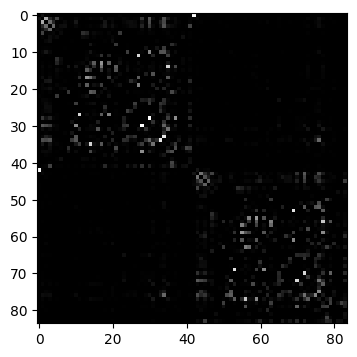

In [11]:
D = vbi.LoadSample(nn=84)
weights = D.get_weights()
nn = weights.shape[0]
print(f"number of nodes: {nn}")

fig, ax = plt.subplots(1, 1, figsize=(4, 4.5))
ax.imshow(weights, cmap="gray", vmin=0, vmax=1);

In [12]:
par = dict(
    weights=weights,
    dt=0.1,
    t_end=2000.0,
    t_cut=101.0,
    noise_amp=0.001,
    g_e=0.0,
    g_i=0.0,
    P=1.22,
    RECORD_EI="EI",
    decimate=1,
    seed=seed,
)
sde = WC_sde(par)
print(sde)

Wilson-Cowan (Numba) parameters:
nn = 84
dt = 0.1
t_end = 2000.0
t_cut = 101.0
decimate = 1
noise_amp = 0.001
g_e = 0.0
g_i = 0.0
a_e = 1.3
a_i = 2.0
b_e = 4.0
b_i = 3.7
k_e = 0.994
k_i = 0.999


In [13]:
def preprocess(x):
    # x = x - np.mean(x, axis=1, keepdims=True)
    return x


def wrapper(par, p, cfg, return_labels=False):
    sde = WC_sde(par)
    sim = sde.run({"g_e": p})
    stat_vec = extract_features(
        [sim["E"].T],
        fs=1.0 / par["dt"] / par["decimate"],
        cfg=cfg,
        preprocess=preprocess,
        preprocess_args={},
        n_workers=1,
        verbose=False,
    )
    values = stat_vec.values
    if return_labels:
        labels = stat_vec.labels
        return values[0], labels
    return values[0]

In [14]:
nperseg = 1024
cfg = get_features_by_domain(domain="spectral")
cfg = get_features_by_given_names(cfg, names=["spectrum_stats"])
cfg = update_cfg(
    cfg,
    "spectrum_stats",
    parameters={
        "fs": 1.0 / (par["dt"] * par["decimate"]) * 1000,
        "method": "welch",
        "nperseg": nperseg,
        "average": True,
    },
)
report_cfg(cfg)

Selected features:
------------------
■ Domain: spectral
 ▢ Function:  spectrum_stats
   ▫ description:  Computes the spectrum of the signal.
   ▫ function   :  vbi.feature_extraction.features.spectrum_stats
   ▫ parameters :  {'fs': 10000.0, 'nperseg': 1024, 'indices': None, 'verbose': False, 'average': True, 'method': 'welch', 'features': ['spectral_distance', 'fundamental_frequency', 'max_frequency', 'max_psd', 'median_frequency', 'spectral_centroid', 'spectral_kurtosis', 'spectral_variation']}
   ▫ tag        :  all
   ▫ use        :  yes


In [15]:
num_simulations = 500
g_min, g_max = 0.0, 1.0
prior_min = [g_min] 
prior_max = [g_max]
prior = utils.BoxUniform(low=torch.tensor(prior_min), high=torch.tensor(prior_max))

obj = Inference()
theta = obj.sample_prior(prior, num_simulations, seed=seed)
theta_np = theta.numpy().squeeze()

In [16]:
import tqdm 

def batch_run(par, theta, cfg, n_workers=-1):

    def update_bar(_):
        pbar.update()
        
    n = len(theta)

    with mp.Pool(processes=n_workers) as pool:
        with tqdm.tqdm(total=n) as pbar:
            async_results = [pool.apply_async(wrapper,
                            args=(par, theta[i], cfg),
                            callback=update_bar)
                            for i in range(n)]
            A = [r.get() for r in async_results]
            return A


In [17]:
values, labels = wrapper(par, theta_np[0], cfg, return_labels=True)
print(np.array(values).shape)
print(labels)

(8,)
['spectral_distance_0', 'fundamental_frequency_0', 'max_frequency_0', 'max_psd_0', 'median_frequency_0', 'spectral_centroid_0', 'spectral_kurtosis_0', 'spectral_variation_0']


In [ ]:
X = batch_run(par, theta_np, cfg, n_workers=10)
X = np.array(X)

In [19]:
X.shape

(500, 8)

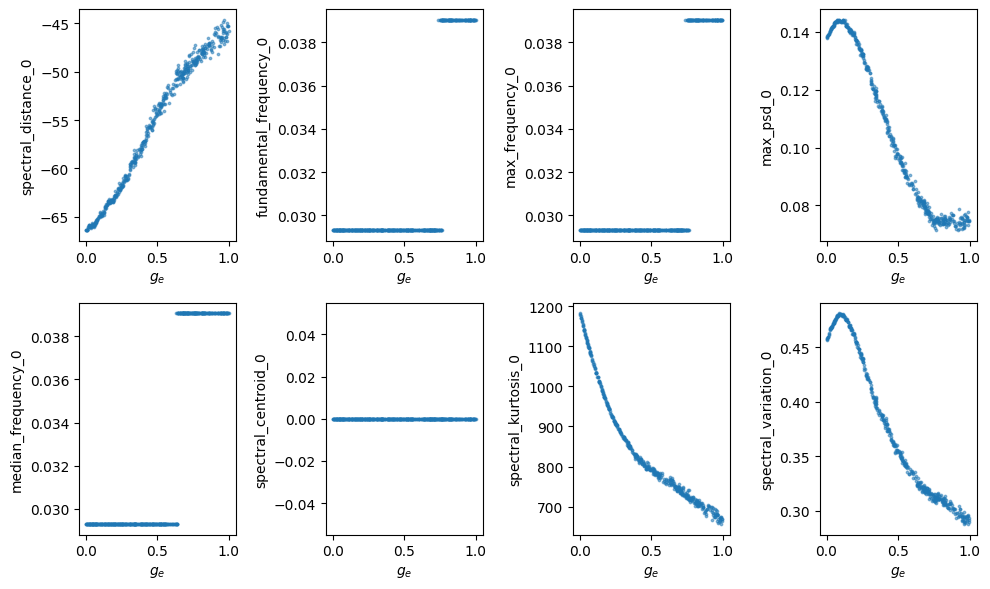

In [20]:
fig, axes = plt.subplots(2, 4, figsize=(10, 6))
axes = axes.flatten()

for i in range(X.shape[1]):
    axes[i].scatter(theta_np, X[:, i], s=3, alpha=0.5)
    axes[i].set_xlabel(r"$g_e$")
    axes[i].set_ylabel(labels[i])
    
plt.tight_layout()

In [21]:
import pandas as pd 
# make a dataframe from features
df = pd.DataFrame(X, columns=labels)
df.head()

,spectral_distance_0,fundamental_frequency_0,max_frequency_0,max_psd_0,median_frequency_0,spectral_centroid_0,spectral_kurtosis_0,spectral_variation_0
0,-49.635582,0.029297,0.029297,0.078133,0.039062,0.0,739.930969,0.317257
1,-50.002735,0.029297,0.029297,0.078317,0.039062,0.0,733.733948,0.317122
2,-62.859879,0.029297,0.029297,0.137202,0.029297,0.0,945.388855,0.455138
3,-60.187119,0.029297,0.029297,0.124175,0.029297,0.0,870.633911,0.415954
4,-46.423111,0.039062,0.039062,0.075966,0.039062,0.0,665.119324,0.293691


In [22]:
# drop features with small variance vs g_e
remaining_features = df.columns[df.var() > 1e-5].tolist()
remaining_indices = [df.columns.get_loc(col) for col in remaining_features]
remaining_features, remaining_indices

(['spectral_distance_0',
  'fundamental_frequency_0',
  'max_frequency_0',
  'max_psd_0',
  'median_frequency_0',
  'spectral_kurtosis_0',
  'spectral_variation_0'],
 [0, 1, 2, 3, 4, 6, 7])

In [ ]:
obj_inf = Inference()
X = torch.tensor(X[:, remaining_indices], dtype=torch.float32)
posterior = obj_inf.train(theta, X, prior, num_threads=4)

In [24]:
torch.save(posterior, os.path.join(path, "posterior.pt"))

In [25]:
theta_true = 0.27
x_observed = wrapper(par, theta_true, cfg)[remaining_indices]

In [26]:
x_observed

array([-6.1471275e+01,  2.9296875e-02,  2.9296875e-02,  1.2989835e-01,
        2.9296875e-02,  8.9161023e+02,  4.3080187e-01], dtype=float32)

In [27]:
samples = obj_inf.sample_posterior(x_observed, 10000, posterior)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

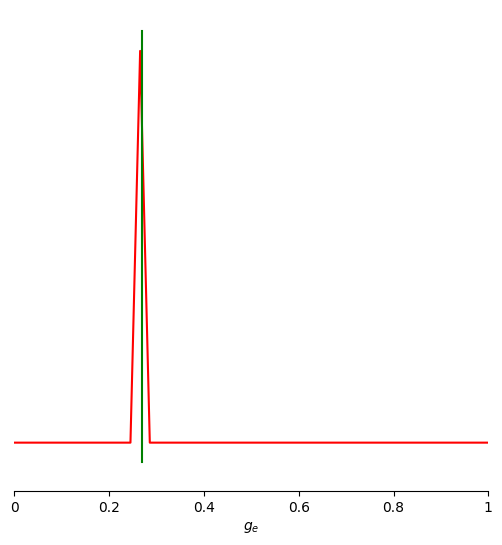

In [28]:
limits = [(prior_min[0], prior_max[0])]
points = [[theta_true]]
fig, ax = pairplot(
    samples=samples,
    limits=limits,
    points=points,
    figsize=(8, 6),
    labels=[r"$g_e$"],
    diag='kde',
    fig_kwargs=dict(
        points_offdiag=dict(marker="*", markersize=5),
        points_colors=["g"]),
    diag_kwargs={"mpl_kwargs": {"color": "r"}},
    upper_kwargs={"mpl_kwargs": {"cmap": "Blues"}},
)
